# Feature Extraction using Convolutional Neural Networks
[GitHub Tutorial:CIFAR 10 feature extraction using pretrained convolutional depp neural networks from keras library](https://github.com/rnoxy/cifar10-cnn/blob/master/Feature_extraction_using_keras.ipynb)

In [2]:
#Github code
network_names = [ 'incv3', 'resnet50', 'vgg16', 'vgg19' ]

print("Available networks = ", network_names)
cnnid = int( input("Please choose the CNN network [0-{n}]: ".format(n=len(network_names)-1)) )
selected_network = network_names[cnnid]
print("Selected network: ", selected_network)

Available networks =  ['incv3', 'resnet50', 'vgg16', 'vgg19']
Please choose the CNN network [0-3]: 1
Selected network:  resnet50


In [3]:
 pip install myutils

  Created wheel for myutils: filename=myutils-0.0.21-py3-none-any.whl size=1364 sha256=3b0b33564ed13aaef68b9322753b79c389a9f9ee2bc0969f26d0b8d0d80cee69
  Stored in directory: /root/.cache/pip/wheels/8e/89/9f/ab7f23dcc9ba30d64a298bcfc29c4e7e9ec59110ddc69aac12
Successfully built myutils


In [4]:
#github
import time
import myutils
import numpy as np
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()
from keras.layers import Input, Dense, AveragePooling2D, GlobalAveragePooling2D, Conv2D
from keras import backend as K

Instructions for updating:
non-resource variables are not supported in the long term


## Load CIFAR10 data

170508288/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


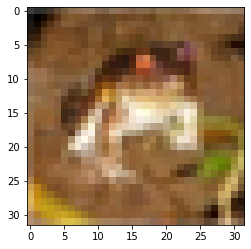

In [5]:
#github
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

n_training = X_train.shape[0]
n_testing = X_test.shape[0]

y_train = y_train.flatten()
y_test  = y_test.flatten()

print( X_train.shape, y_train.shape,  X_test.shape, y_test.shape )

from matplotlib import pyplot as plt
plt.imshow( X_train[0]  )
plt.show()

## Create model

In [6]:
#github
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet     import ResNet50
from keras.applications.vgg16        import VGG16
from keras.applications.vgg19        import VGG19

input_shape = {
    'incv3'   : (299,299,3),
    'resnet50': (224,224,3),
    'vgg16'   : (224,224,3),
    'vgg19'   : (224,224,3)
}[selected_network]

def create_model_incv3():
    tf_input = Input(shape=input_shape)
    model = InceptionV3(input_tensor=tf_input, weights='imagenet', include_top=False)
    output_pooled = AveragePooling2D((8, 8), strides=(8, 8))(model.output)
    return Model(model.input, output_pooled)

def create_model_resnet50():
    tf_input = Input(shape=input_shape)
    model = ResNet50(input_tensor=tf_input, include_top=False)
    convolutional_layer = Conv2D(500,1)(model.output)
    output_pooled = AveragePooling2D((7, 7))(convolutional_layer)
    return Model(model.input, output_pooled )

def create_model_vgg16():
    tf_input = Input(shape=input_shape)
    model = VGG16(input_tensor=tf_input, include_top=False)
    output_pooled = AveragePooling2D((7, 7))(model.output)
    return Model(model.input, output_pooled )

def create_model_vgg19():
    tf_input = Input(shape=input_shape)
    model = VGG19(input_tensor=tf_input, include_top=False)
    output_pooled = AveragePooling2D((7, 7))(model.output)
    return Model(model.input, output_pooled )

create_model = {
    'incv3'    : create_model_incv3,
    'resnet50' : create_model_resnet50,
    'vgg16'    : create_model_vgg16,
    'vgg19'    : create_model_vgg19
}[selected_network]

## Data generator for tensorflow

[Tensorflow 1 to 2](https://stackoverflow.com/questions/60966376/best-practice-to-write-code-compatible-to-both-tensorflow-1-and-2)

In [7]:
#github
# tensorflow placeholder for batch of images from CIFAR10 dataset
batch_of_images_placeholder = tf.placeholder("uint8", (None, 32, 32, 3))

batch_size = {
    'incv3'    : 16,
    'resnet50' : 16,
    'vgg16'    : 16,
    'vgg19'    : 16
}[selected_network]

# Inception default size is 299x299
tf_resize_op = tf.image.resize(batch_of_images_placeholder, (input_shape[:2]), method='bilinear')

In [8]:
#github
# data generator for tensorflow session
from keras.applications.inception_v3 import preprocess_input as incv3_preprocess_input
from keras.applications.resnet     import preprocess_input as resnet50_preprocess_input
from keras.applications.vgg16        import preprocess_input as vgg16_preprocess_input
from keras.applications.vgg19        import preprocess_input as vgg19_preprocess_input

preprocess_input = {
    'incv3'   : incv3_preprocess_input,
    'resnet50': resnet50_preprocess_input,
    'vgg16'   : vgg16_preprocess_input,
    'vgg19'   : vgg19_preprocess_input
}[selected_network]

def data_generator(sess,data,labels):
    def generator():
        start = 0
        end = start + batch_size
        n = data.shape[0]
        while True:
            batch_of_images_resized = sess.run(tf_resize_op, {batch_of_images_placeholder: data[start:end]})
            batch_of_images__preprocessed = preprocess_input(batch_of_images_resized)
            batch_of_labels = labels[start:end]
            start += batch_size
            end   += batch_size
            if start >= n:
                start = 0
                end = batch_size
            yield (batch_of_images__preprocessed, batch_of_labels)
    return generator

## Feature extraction

In [9]:
with tf.Session() as sess:
    # setting tensorflow session to Keras
    K.set_session(sess)
    # setting phase to training
    K.set_learning_phase(1)  # 0 - test,  1 - train

    model = create_model()

    data_train_gen = data_generator(sess, X_train, y_train)
    ftrs_training = model.predict_generator(data_train_gen(), n_training/batch_size, verbose=1)

    data_test_gen = data_generator(sess, X_test, y_test)
    ftrs_testing = model.predict_generator(data_test_gen(), n_testing/batch_size, verbose=1)

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


94781440/94765736 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


In [10]:
#github
features_training = np.array( [ftrs_training[i].flatten() for i in range(n_training)] )
features_testing  = np.array( [ftrs_testing[i].flatten()  for i in range(n_testing )] )

#np.savez_compressed("features/CIFAR10_{}-keras_features.npz".format(selected_network),features_training=features_training,features_testing=features_testing,labels_training=y_train,labels_testing=y_test)

## Feature visualization

### Feature analysis (using PCA)

In [11]:
#github
import numpy as np
import myutils

#data = np.load("features/CIFAR10_{}-keras_features.npz".format(selected_network))

X_training = features_training
y_training = y_train

X_testing = features_testing
y_testing = y_test

# data_training, data_testing = myutils.load_CIFAR_dataset(shuffle=False)
# assert( (np.array( [data_training[i][1] for i in range(len(data_training))] ) == y_training).all() )
# assert( (np.array( [data_testing[i][1] for i in range(len(data_testing))] ) == y_testing).all() )
print( 'X_training size = {}'.format(X_training.shape))

X_training size = (50000, 500)


# File export

In [12]:
import pandas as pd
y_training_1=np.reshape(y_training,(50000,1))
y_testing_1=np.reshape(y_testing,(10000,1))
data_train= np.concatenate((X_training,y_training_1),axis=1)
data_test= np.concatenate((X_testing,y_testing_1),axis=1)
df_train=pd.DataFrame(data=data_train)
df_test=pd.DataFrame(data=data_test)

In [13]:
df_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500
0,0.035466,0.452695,0.241784,0.201210,-0.116900,0.226909,-0.363317,-0.182914,-0.348696,-0.576151,0.117907,-0.483221,-1.011735,-0.165113,0.150703,-0.693555,-0.758254,0.246651,-0.641634,-0.219387,-0.244312,0.341766,0.418458,0.939665,0.097320,0.806685,1.451283,-0.715968,0.613428,0.025169,-0.834538,0.011318,-0.357212,-1.440609,-0.069091,0.639753,-1.019454,-0.816901,0.307113,0.501294,...,0.378953,0.070494,-0.021555,-0.795838,0.811607,0.716863,0.728078,-0.813399,0.263423,0.477726,-0.070552,-0.904682,-0.022625,-0.844351,-1.591583,0.592721,-0.054163,0.532328,0.335223,-1.237635,-0.939059,0.037315,0.290162,-0.375776,0.961826,-1.223180,0.687735,0.901815,0.650097,-0.183120,0.566970,0.001845,-1.130159,-0.878309,0.003420,0.290332,1.131485,-0.320462,-0.343801,6.0
1,-0.766034,1.091952,0.031272,0.734734,-0.862183,1.026400,-1.474023,1.093964,-1.207635,-0.169637,-0.108057,0.305222,-1.148696,0.295981,-0.166686,0.364767,-0.244070,0.409729,0.099093,-0.229943,-1.280819,0.155815,0.338018,0.419407,0.004239,1.637856,0.224083,0.910466,-0.418531,-0.486105,-0.609578,0.259014,0.455805,0.971387,0.810963,0.615551,-0.629186,0.288702,0.525788,0.885397,...,1.048475,0.274630,1.644200,-0.885797,1.894946,-0.889232,-0.354689,-1.021508,-0.546168,0.522772,-0.258020,-0.647133,-0.258479,-1.548250,-0.220917,-0.529242,-0.532134,0.739306,0.634473,0.081989,0.105143,-0.248831,-0.155488,-0.591672,-0.460576,-1.827889,0.818153,1.823468,-0.513802,0.420000,-0.265237,-1.432423,-0.520838,-0.441258,-0.853595,0.154124,-0.617192,0.584102,0.457497,9.0
2,-1.244990,2.269845,-1.050468,0.363221,1.001979,1.561393,-0.784115,0.008655,0.957987,-1.051487,0.222251,0.529149,-1.417867,0.161126,-0.970632,0.031806,-0.753573,1.085259,0.180815,0.364401,0.439716,-0.629434,0.672442,0.376549,-0.850583,-0.076744,0.032751,0.475015,-0.291165,-0.615165,-0.325979,-0.026669,0.520018,-0.597303,-0.667398,1.010435,0.044346,0.121214,0.568079,0.510030,...,-0.572444,0.435443,0.774399,-0.287148,0.829126,-1.053246,-0.924003,-0.667768,-1.426793,0.043472,0.679349,0.593272,-0.416155,-0.744702,0.894374,0.514069,-0.389001,0.916403,1.883728,-0.450718,-1.186791,0.056779,-1.521234,0.948790,0.234501,-0.742183,0.132244,0.871790,0.430038,0.700010,-0.056282,0.482993,-1.048903,-1.325803,0.756491,-0.235450,-0.492835,1.087334,0.091229,9.0
3,-0.383284,-0.164137,-0.474136,-0.380158,-0.683132,0.001506,-0.898478,-0.427881,-0.150358,0.822465,0.206981,-0.342645,-0.511272,-0.177784,0.017698,0.382138,-0.656827,0.183363,-0.052774,0.715541,0.334730,-0.541373,1.983008,0.855839,-0.580927,0.890088,0.771272,-0.050606,0.428261,1.116982,-1.441217,0.358251,0.290528,0.211381,-0.219580,0.539932,-0.563015,-0.034702,-0.241032,1.130583,...,-1.001123,0.719704,-0.376578,0.060632,0.372613,0.132824,0.960142,-0.979676,-0.007188,-0.526615,-0.507744,-0.235011,-0.436524,-1.293055,-0.580064,-0.126303,1.130272,0.767753,-0.096308,-0.287781,-0.905575,-0.558007,-0.592238,0.027211,0.239876,-1.674988,0.347261,1.775059,-0.043354,0.762795,-0.631710,-0.693727,-1.643840,-0.497716,-0.848866,-0.914435,0.267591,-0.379273,-0.286321,4.0
4,0.072264,1.814786,-0.973915,-0.249140,-0.391023,0.630457,-1.792245,-0.642354,-0.983033,-0.082627,-1.947373,1.413606,-1.915847,0.115512,-0.885649,-0.782908,-1.079884,0.460354,1.119178,-0.855561,-0.368848,-1.049609,0.922576,0.567761,0.714054,0.672036,0.773339,-1.058615,0.980699,-0.790443,0.058289,0.308008,-0.076618,-0.350164,-0.595656,1.520563,0.091339,1.106474,0.680478,1.719962,...,0.406781,-0.407983,2.535248,-0.252271,0.779483,1.086332,0.026790,-1.440535,-1.313228,-0.488714,-0.595127,-1.299001,-1.095189,-0.691706,-0.207580,1.388494,-1.237399,0.057345,1.515547,0.229362,-0.407721,-0.030709,-1.239860,-0.700323,-0.115542,-0.024519,-0.052286,1.100171,0.255463,0.435489,0.673630,

In [14]:
df_train_final=df_train.rename({500:'Class Label'},axis=1)
df_train_final

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,Class Label
0,0.035466,0.452695,0.241784,0.201210,-0.116900,0.226909,-0.363317,-0.182914,-0.348696,-0.576151,0.117907,-0.483221,-1.011735,-0.165113,0.150703,-0.693555,-0.758254,0.246651,-0.641634,-0.219387,-0.244312,0.341766,0.418458,0.939665,0.097320,0.806685,1.451283,-0.715968,0.613428,0.025169,-0.834538,0.011318,-0.357212,-1.440609,-0.069091,0.639753,-1.019454,-0.816901,0.307113,0.501294,...,0.378953,0.070494,-0.021555,-0.795838,0.811607,0.716863,0.728078,-0.813399,0.263423,0.477726,-0.070552,-0.904682,-0.022625,-0.844351,-1.591583,0.592721,-0.054163,0.532328,0.335223,-1.237635,-0.939059,0.037315,0.290162,-0.375776,0.961826,-1.223180,0.687735,0.901815,0.650097,-0.183120,0.566970,0.001845,-1.130159,-0.878309,0.003420,0.290332,1.131485,-0.320462,-0.343801,6.0
1,-0.766034,1.091952,0.031272,0.734734,-0.862183,1.026400,-1.474023,1.093964,-1.207635,-0.169637,-0.108057,0.305222,-1.148696,0.295981,-0.166686,0.364767,-0.244070,0.409729,0.099093,-0.229943,-1.280819,0.155815,0.338018,0.419407,0.004239,1.637856,0.224083,0.910466,-0.418531,-0.486105,-0.609578,0.259014,0.455805,0.971387,0.810963,0.615551,-0.629186,0.288702,0.525788,0.885397,...,1.048475,0.274630,1.644200,-0.885797,1.894946,-0.889232,-0.354689,-1.021508,-0.546168,0.522772,-0.258020,-0.647133,-0.258479,-1.548250,-0.220917,-0.529242,-0.532134,0.739306,0.634473,0.081989,0.105143,-0.248831,-0.155488,-0.591672,-0.460576,-1.827889,0.818153,1.823468,-0.513802,0.420000,-0.265237,-1.432423,-0.520838,-0.441258,-0.853595,0.154124,-0.617192,0.584102,0.457497,9.0
2,-1.244990,2.269845,-1.050468,0.363221,1.001979,1.561393,-0.784115,0.008655,0.957987,-1.051487,0.222251,0.529149,-1.417867,0.161126,-0.970632,0.031806,-0.753573,1.085259,0.180815,0.364401,0.439716,-0.629434,0.672442,0.376549,-0.850583,-0.076744,0.032751,0.475015,-0.291165,-0.615165,-0.325979,-0.026669,0.520018,-0.597303,-0.667398,1.010435,0.044346,0.121214,0.568079,0.510030,...,-0.572444,0.435443,0.774399,-0.287148,0.829126,-1.053246,-0.924003,-0.667768,-1.426793,0.043472,0.679349,0.593272,-0.416155,-0.744702,0.894374,0.514069,-0.389001,0.916403,1.883728,-0.450718,-1.186791,0.056779,-1.521234,0.948790,0.234501,-0.742183,0.132244,0.871790,0.430038,0.700010,-0.056282,0.482993,-1.048903,-1.325803,0.756491,-0.235450,-0.492835,1.087334,0.091229,9.0
3,-0.383284,-0.164137,-0.474136,-0.380158,-0.683132,0.001506,-0.898478,-0.427881,-0.150358,0.822465,0.206981,-0.342645,-0.511272,-0.177784,0.017698,0.382138,-0.656827,0.183363,-0.052774,0.715541,0.334730,-0.541373,1.983008,0.855839,-0.580927,0.890088,0.771272,-0.050606,0.428261,1.116982,-1.441217,0.358251,0.290528,0.211381,-0.219580,0.539932,-0.563015,-0.034702,-0.241032,1.130583,...,-1.001123,0.719704,-0.376578,0.060632,0.372613,0.132824,0.960142,-0.979676,-0.007188,-0.526615,-0.507744,-0.235011,-0.436524,-1.293055,-0.580064,-0.126303,1.130272,0.767753,-0.096308,-0.287781,-0.905575,-0.558007,-0.592238,0.027211,0.239876,-1.674988,0.347261,1.775059,-0.043354,0.762795,-0.631710,-0.693727,-1.643840,-0.497716,-0.848866,-0.914435,0.267591,-0.379273,-0.286321,4.0
4,0.072264,1.814786,-0.973915,-0.249140,-0.391023,0.630457,-1.792245,-0.642354,-0.983033,-0.082627,-1.947373,1.413606,-1.915847,0.115512,-0.885649,-0.782908,-1.079884,0.460354,1.119178,-0.855561,-0.368848,-1.049609,0.922576,0.567761,0.714054,0.672036,0.773339,-1.058615,0.980699,-0.790443,0.058289,0.308008,-0.076618,-0.350164,-0.595656,1.520563,0.091339,1.106474,0.680478,1.719962,...,0.406781,-0.407983,2.535248,-0.252271,0.779483,1.086332,0.026790,-1.440535,-1.313228,-0.488714,-0.595127,-1.299001,-1.095189,-0.691706,-0.207580,1.388494,-1.237399,0.057345,1.515547,0.229362,-0.407721,-0.030709,-1.239860,-0.700323,-0.115542,-0.024519,-0.052286,1.100171,0.255463,0.435489,0

In [15]:
df_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500
0,0.505824,0.767553,-0.329235,0.746054,0.487215,0.962945,0.168215,0.506993,-0.414161,-0.099524,-0.804885,1.112754,-0.847995,-1.217942,-1.113935,-0.268776,-1.506465,0.798648,-1.044030,0.441808,-0.106151,-1.069387,0.576597,1.756938,0.303822,0.387312,0.516093,1.120116,0.114248,-1.146208,-1.487447,-0.523793,-0.282657,-0.385915,0.202413,0.998307,-0.925074,1.048730,-0.877775,0.807323,...,-0.950522,0.346865,-0.074719,-1.715640,1.502972,-0.282268,1.234529,-1.543702,-0.603312,-0.034630,-1.395128,-0.236959,0.045706,-1.476069,-0.024979,0.932091,0.469960,0.098436,0.821931,-1.239613,-1.880231,-0.514876,-0.243266,0.597666,0.517415,0.056970,-0.732685,1.289461,-0.768243,0.552617,0.080219,-0.465639,-0.338480,-0.761921,-0.007919,0.662673,-0.223745,0.176554,0.023239,3.0
1,0.453027,1.485499,-0.624303,-0.081389,-0.260737,0.478533,-2.476156,0.156468,-0.474596,0.033861,0.545625,0.433413,-1.972890,0.290743,-1.973778,-0.475235,-1.781175,1.068415,1.005253,-0.656264,-0.003200,-0.496610,0.026477,0.443674,-0.224597,0.849844,-0.172658,-0.360722,0.587844,-0.341983,-0.582356,-0.379415,0.296919,0.825219,-0.406099,1.376343,-0.210946,0.433067,0.709072,2.518977,...,-0.603651,1.150224,0.754804,0.418294,0.052363,-0.041341,0.641952,-0.057459,-2.000947,0.697140,0.024479,-1.378869,0.653363,-0.834687,0.869680,0.452458,-0.067588,-0.850607,1.814525,-0.734690,0.092677,0.226697,-0.468530,-0.396180,0.145119,-0.602187,0.323364,1.466596,0.775963,-0.165237,-0.592242,-0.781079,-0.424645,-0.817175,-0.097791,0.706349,0.236363,1.415751,-0.444547,8.0
2,-0.856389,0.598738,-0.762009,-0.069201,-0.238664,0.902688,-0.284905,0.352608,-1.108591,0.351414,-1.933172,0.765149,0.039958,0.093950,-0.165339,0.395009,-1.358330,0.603570,0.086271,-0.752239,-1.220245,0.196699,1.487599,0.607462,0.259367,0.426604,0.289766,-0.025035,0.867583,-1.202398,-0.403873,-0.031610,0.382361,-0.819527,-1.553383,1.519196,-0.262971,0.106917,0.931659,0.748220,...,-0.620381,0.694539,1.634360,-0.636961,0.215793,-0.350497,0.694977,0.274605,-1.404850,-0.533967,-0.112606,-0.057440,-0.130408,0.245033,0.896450,0.061626,-0.646897,-0.281191,0.805194,-0.151007,-1.279649,0.227531,-0.163410,-0.835158,-0.092252,-1.276857,0.051272,1.364141,-0.215496,0.494061,0.081080,-0.506649,-0.428221,-1.070905,0.229452,-0.910718,-0.296580,-0.027122,0.791081,8.0
3,-0.304131,0.690825,0.039456,-0.524731,-0.784449,0.367219,0.051311,-0.315374,0.378880,0.426241,1.395982,0.680413,-0.316122,-0.375293,-0.856607,0.266831,-0.652618,0.087643,-0.339384,0.842606,0.607209,-0.282269,0.060774,0.844475,-0.588812,1.198332,1.178937,1.358863,-0.654632,-0.768045,0.451261,0.110077,1.014007,-0.651054,0.186890,0.118194,-0.631615,1.679467,0.951488,0.881218,...,0.192242,0.847137,0.471608,0.721192,0.632975,-0.023871,0.511579,-0.560560,-0.992985,-0.040412,0.663396,-0.874534,-0.513851,-0.388210,0.461254,-0.497221,-1.232034,-0.937582,1.493485,1.066211,-0.383070,-0.547175,0.420778,-0.885401,0.433464,-0.150073,0.576389,0.778004,-0.212884,-0.162465,-0.097235,-0.257835,0.036201,-0.188089,-0.140303,-1.088049,0.442668,0.418999,-0.639677,0.0
4,-0.651563,0.677218,0.154477,-0.250700,-0.245509,-0.633612,0.312596,-1.179572,0.826558,-1.637960,-0.236024,-0.163939,-0.384533,0.573662,-1.195534,-1.256578,-1.210451,0.368499,0.041192,0.508765,-0.233786,-0.328207,-0.214245,-0.008475,-1.170623,1.877733,-0.017287,-1.134038,-0.383513,0.915223,0.092699,-0.454797,0.543018,0.452257,0.197733,-0.040274,0.967701,-1.335897,1.390086,0.736112,...,0.890783,0.178882,0.563643,-0.365001,0.959180,-1.104550,0.448746,-0.873423,0.156367,-0.160077,0.593214,0.342564,-0.185282,-1.019056,-1.377135,0.277073,0.001203,1.071097,-0.663507,-0.290961,-1.155606,-0.123796,-0.398224,-0.811900,1.009761,-1.071457,-0.030554,2.531304,0.408088,-0.163964,0.952352

In [16]:
df_test_final=df_test.rename({500:'Class Label'},axis=1)
df_test_final

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,Class Label
0,0.505824,0.767553,-0.329235,0.746054,0.487215,0.962945,0.168215,0.506993,-0.414161,-0.099524,-0.804885,1.112754,-0.847995,-1.217942,-1.113935,-0.268776,-1.506465,0.798648,-1.044030,0.441808,-0.106151,-1.069387,0.576597,1.756938,0.303822,0.387312,0.516093,1.120116,0.114248,-1.146208,-1.487447,-0.523793,-0.282657,-0.385915,0.202413,0.998307,-0.925074,1.048730,-0.877775,0.807323,...,-0.950522,0.346865,-0.074719,-1.715640,1.502972,-0.282268,1.234529,-1.543702,-0.603312,-0.034630,-1.395128,-0.236959,0.045706,-1.476069,-0.024979,0.932091,0.469960,0.098436,0.821931,-1.239613,-1.880231,-0.514876,-0.243266,0.597666,0.517415,0.056970,-0.732685,1.289461,-0.768243,0.552617,0.080219,-0.465639,-0.338480,-0.761921,-0.007919,0.662673,-0.223745,0.176554,0.023239,3.0
1,0.453027,1.485499,-0.624303,-0.081389,-0.260737,0.478533,-2.476156,0.156468,-0.474596,0.033861,0.545625,0.433413,-1.972890,0.290743,-1.973778,-0.475235,-1.781175,1.068415,1.005253,-0.656264,-0.003200,-0.496610,0.026477,0.443674,-0.224597,0.849844,-0.172658,-0.360722,0.587844,-0.341983,-0.582356,-0.379415,0.296919,0.825219,-0.406099,1.376343,-0.210946,0.433067,0.709072,2.518977,...,-0.603651,1.150224,0.754804,0.418294,0.052363,-0.041341,0.641952,-0.057459,-2.000947,0.697140,0.024479,-1.378869,0.653363,-0.834687,0.869680,0.452458,-0.067588,-0.850607,1.814525,-0.734690,0.092677,0.226697,-0.468530,-0.396180,0.145119,-0.602187,0.323364,1.466596,0.775963,-0.165237,-0.592242,-0.781079,-0.424645,-0.817175,-0.097791,0.706349,0.236363,1.415751,-0.444547,8.0
2,-0.856389,0.598738,-0.762009,-0.069201,-0.238664,0.902688,-0.284905,0.352608,-1.108591,0.351414,-1.933172,0.765149,0.039958,0.093950,-0.165339,0.395009,-1.358330,0.603570,0.086271,-0.752239,-1.220245,0.196699,1.487599,0.607462,0.259367,0.426604,0.289766,-0.025035,0.867583,-1.202398,-0.403873,-0.031610,0.382361,-0.819527,-1.553383,1.519196,-0.262971,0.106917,0.931659,0.748220,...,-0.620381,0.694539,1.634360,-0.636961,0.215793,-0.350497,0.694977,0.274605,-1.404850,-0.533967,-0.112606,-0.057440,-0.130408,0.245033,0.896450,0.061626,-0.646897,-0.281191,0.805194,-0.151007,-1.279649,0.227531,-0.163410,-0.835158,-0.092252,-1.276857,0.051272,1.364141,-0.215496,0.494061,0.081080,-0.506649,-0.428221,-1.070905,0.229452,-0.910718,-0.296580,-0.027122,0.791081,8.0
3,-0.304131,0.690825,0.039456,-0.524731,-0.784449,0.367219,0.051311,-0.315374,0.378880,0.426241,1.395982,0.680413,-0.316122,-0.375293,-0.856607,0.266831,-0.652618,0.087643,-0.339384,0.842606,0.607209,-0.282269,0.060774,0.844475,-0.588812,1.198332,1.178937,1.358863,-0.654632,-0.768045,0.451261,0.110077,1.014007,-0.651054,0.186890,0.118194,-0.631615,1.679467,0.951488,0.881218,...,0.192242,0.847137,0.471608,0.721192,0.632975,-0.023871,0.511579,-0.560560,-0.992985,-0.040412,0.663396,-0.874534,-0.513851,-0.388210,0.461254,-0.497221,-1.232034,-0.937582,1.493485,1.066211,-0.383070,-0.547175,0.420778,-0.885401,0.433464,-0.150073,0.576389,0.778004,-0.212884,-0.162465,-0.097235,-0.257835,0.036201,-0.188089,-0.140303,-1.088049,0.442668,0.418999,-0.639677,0.0
4,-0.651563,0.677218,0.154477,-0.250700,-0.245509,-0.633612,0.312596,-1.179572,0.826558,-1.637960,-0.236024,-0.163939,-0.384533,0.573662,-1.195534,-1.256578,-1.210451,0.368499,0.041192,0.508765,-0.233786,-0.328207,-0.214245,-0.008475,-1.170623,1.877733,-0.017287,-1.134038,-0.383513,0.915223,0.092699,-0.454797,0.543018,0.452257,0.197733,-0.040274,0.967701,-1.335897,1.390086,0.736112,...,0.890783,0.178882,0.563643,-0.365001,0.959180,-1.104550,0.448746,-0.873423,0.156367,-0.160077,0.593214,0.342564,-0.185282,-1.019056,-1.377135,0.277073,0.001203,1.071097,-0.663507,-0.290961,-1.155606,-0.123796,-0.398224,-0.811900,1.009761,-1.071457,-0.030554,2.531304,0.408088,-0.163964,

In [17]:
df_train_final.to_csv("TrainingDataCifar10ResnetSize500.csv")

In [18]:
df_test_final.to_csv("TestingDataCifar10RensetSize500.csv")

# Classifier

In [19]:
#github
X = X_training

In [20]:
from sklearn.preprocessing import LabelBinarizer
#custom code
Y_train=LabelBinarizer().fit_transform(y_training)
Y_test=LabelBinarizer().fit_transform(y_testing)

In [21]:
from sklearn.neural_network import MLPClassifier
model=MLPClassifier()

In [ ]:
#Please see the following website for reference
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

import numpy as np

# Number of hidden layers for the neural network
hidden_layer_sizes = [(20,),(10,10),(7,7,6),(5,5,5,5),(4,4,4,4,4)]

# activation function for neural network
#x=(a1)x1+(a2)x2+(a3)x3+....(an)(xn) 
#identity: f(x)=x
# logistic: f(x)=
# tanh:
# relu:
activation = ['logistic','tanh','relu']

# Maximum number of levels in tree
solver = ['lbfgs','sgd','adam']

# Minimum number of samples required to split a node
alpha = [0.0005, 0.001,0.005]

# Method of selecting samples for training each tree
learning_rate = ['constant', 'invscaling','adaptive']

# Number of features to consider at every split
power_t = [0.25, 0.5,0.75]

# Maximum number of levels in tree
max_iter = [100,200,300]

# Method of selecting samples for training each tree
tol = [1e-5,1e-4,1e-3]

# Minimum number of samples required to split a node
n_iter_no_change = [10, 50, 100]


# Create the random grid
random_grid = {'hidden_layer_sizes': hidden_layer_sizes,
               'activation': activation,
               'solver': solver,
               'alpha': alpha,
               'learning_rate': learning_rate,
               'power_t': power_t,
               'max_iter': max_iter,
               'tol': tol,
               'n_iter_no_change': n_iter_no_change}
print(random_grid)

{'hidden_layer_sizes': [(20,), (10, 10), (7, 7, 6), (5, 5, 5, 5), (4, 4, 4, 4, 4)], 'activation': ['logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'], 'alpha': [0.0005, 0.001, 0.005], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'power_t': [0.25, 0.5, 0.75], 'max_iter': [100, 200, 300], 'tol': [1e-05, 0.0001, 0.001], 'n_iter_no_change': [10, 50, 100]}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
model_random= RandomizedSearchCV(estimator=model,param_distributions= random_grid, n_iter=100, cv = 3, verbose=2, n_jobs=-1)

In [ ]:
model_random.fit(X,Y_train)
model_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


{'activation': 'relu',
 'alpha': 0.0005,
 'hidden_layer_sizes': (10, 10),
 'learning_rate': 'constant',
 'max_iter': 200,
 'n_iter_no_change': 100,
 'power_t': 0.5,
 'solver': 'adam',
 'tol': 0.001}

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create the random grid
param_grid = {
 'activation': ['relu'],
 'alpha': [0.0005,0.005],
 'hidden_layer_sizes': [(10, 10)],
 'learning_rate': ['constant','invscaling'],
 'max_iter': [200],
 'n_iter_no_change': [50,100],
 'power_t': [0.5,0.75],
 'solver': ['adam'],
 'tol': [0.0001,0.001]}
print(param_grid)

{'activation': ['relu'], 'alpha': [0.0005, 0.005], 'hidden_layer_sizes': [(10, 10)], 'learning_rate': ['constant', 'invscaling'], 'max_iter': [200], 'n_iter_no_change': [50, 100], 'power_t': [0.5, 0.75], 'solver': ['adam'], 'tol': [0.0001, 0.001]}


In [ ]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
model_grid= GridSearchCV(estimator=model,param_grid= param_grid, cv = 3, verbose=2, n_jobs=-1)

In [ ]:
model_grid.fit(X,Y_train)
model_grid.best_params_

Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


{'activation': 'relu',
 'alpha': 0.005,
 'hidden_layer_sizes': (10, 10),
 'learning_rate': 'constant',
 'max_iter': 200,
 'n_iter_no_change': 100,
 'power_t': 0.75,
 'solver': 'adam',
 'tol': 0.0001}

In [22]:
from sklearn.neural_network import MLPClassifier
model=MLPClassifier(activation='relu',alpha=0.005, hidden_layer_sizes=(10, 10), learning_rate='constant',max_iter=200, n_iter_no_change=100, power_t=0.75, solver='adam',tol=0.0001)


TrainedModel=model.fit(X,Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [23]:

X_t = X_testing

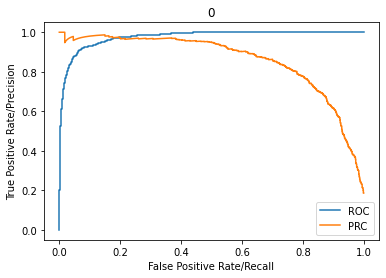

PRC AUC:0.8602159733066176
ROC AUC:0.9751563333333332


In [24]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

probs = TrainedModel.predict_proba(X_t)
fpr1, tpr1, thresholds1 = roc_curve(Y_test[:,0], probs[:,0])
prec1, recall1, thresholds1 = precision_recall_curve(Y_test[:,0], probs[:,0])

plt.plot(fpr1,tpr1,label="ROC")
plt.plot(recall1,prec1,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('0')
plt.show()

print("PRC AUC:" + str(auc(recall1, prec1)))
print("ROC AUC:" + str(auc(fpr1, tpr1)))

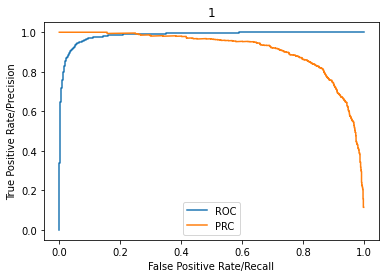

PRC AUC:0.9116059215269153
ROC AUC:0.984669888888889


In [25]:
fpr2, tpr2, thresholds2 = roc_curve(Y_test[:,1], probs[:, 1])
prec2, recall2, thresholds2 = precision_recall_curve(Y_test[:,1], probs[:, 1])

plt.plot(fpr2,tpr2,label="ROC")
plt.plot(recall2,prec2,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('1')
plt.show()

print("PRC AUC:" + str(auc(recall2, prec2)))
print("ROC AUC:" + str(auc(fpr2, tpr2)))

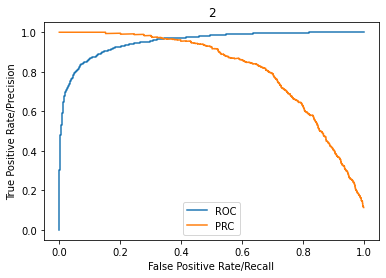

PRC AUC:0.8109826069840015
ROC AUC:0.9520846666666666


In [26]:
fpr3, tpr3, thresholds3 = roc_curve(Y_test[:,2], probs[:, 2])
prec3, recall3, thresholds3 = precision_recall_curve(Y_test[:,2], probs[:, 2])

plt.plot(fpr3,tpr3,label="ROC")
plt.plot(recall3,prec3,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('2')
plt.show()

print("PRC AUC:" + str(auc(recall3, prec3)))
print("ROC AUC:" + str(auc(fpr3, tpr3)))

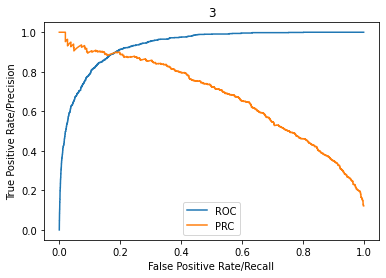

PRC AUC:0.6767796531773389
ROC AUC:0.9345350000000001


In [27]:
fpr4, tpr4, thresholds4 = roc_curve(Y_test[:,3], probs[:, 3])
prec4, recall4, thresholds4 = precision_recall_curve(Y_test[:,3], probs[:, 3])

plt.plot(fpr4,tpr4,label="ROC")
plt.plot(recall4,prec4,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('3')
plt.show()

print("PRC AUC:" + str(auc(recall4, prec4)))
print("ROC AUC:" + str(auc(fpr4, tpr4)))

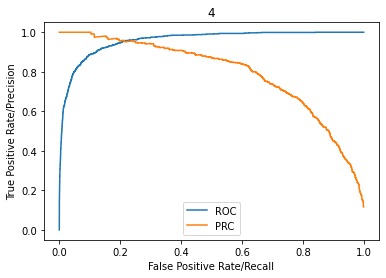

PRC AUC:0.7952029250216777
ROC AUC:0.9585592777777778


In [28]:
fpr5, tpr5, thresholds5 = roc_curve(Y_test[:,4], probs[:, 4])
prec5, recall5, thresholds5 = precision_recall_curve(Y_test[:,4], probs[:, 4])

plt.plot(fpr5,tpr5,label="ROC")
plt.plot(recall5,prec5,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('4')
plt.show()

print("PRC AUC:" + str(auc(recall5, prec5)))
print("ROC AUC:" + str(auc(fpr5, tpr5)))

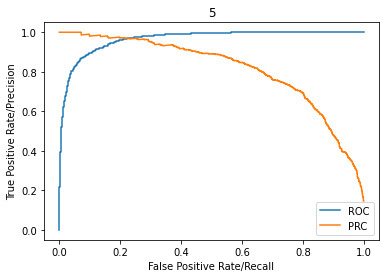

PRC AUC:0.8141229930533129
ROC AUC:0.9648506666666666


In [29]:
fpr6, tpr6, thresholds6 = roc_curve(Y_test[:,5], probs[:, 5])
prec6, recall6, thresholds6 = precision_recall_curve(Y_test[:,5], probs[:, 5])

plt.plot(fpr6,tpr6,label="ROC")
plt.plot(recall6,prec6,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('5')
plt.show()

print("PRC AUC:" + str(auc(recall6, prec6)))
print("ROC AUC:" + str(auc(fpr6, tpr6)))

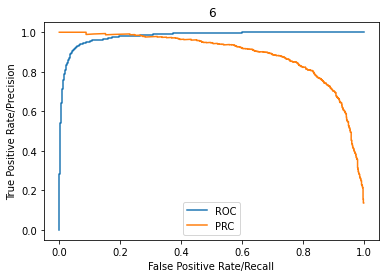

PRC AUC:0.8878618347570374
ROC AUC:0.9799113333333334


In [30]:
fpr7, tpr7, thresholds7 = roc_curve(Y_test[:,6], probs[:, 6])
prec7, recall7, thresholds7 = precision_recall_curve(Y_test[:,6], probs[:, 6])

plt.plot(fpr7,tpr7,label="ROC")
plt.plot(recall7,prec7,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('6')
plt.show()

print("PRC AUC:" + str(auc(recall7, prec7)))
print("ROC AUC:" + str(auc(fpr7, tpr7)))

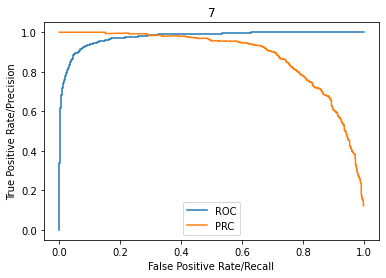

PRC AUC:0.8818945546036348
ROC AUC:0.9753232222222221


In [31]:
fpr8, tpr8, thresholds8 = roc_curve(Y_test[:,7], probs[:, 7])
prec8, recall8, thresholds8 = precision_recall_curve(Y_test[:,7], probs[:, 7])

plt.plot(fpr8,tpr8,label="ROC")
plt.plot(recall8,prec8,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('7')
plt.show()

print("PRC AUC:" + str(auc(recall8, prec8)))
print("ROC AUC:" + str(auc(fpr8, tpr8)))

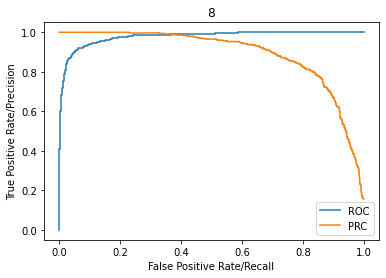

PRC AUC:0.8924800212941046
ROC AUC:0.9774816666666666


In [32]:
fpr9, tpr9, thresholds9 = roc_curve(Y_test[:,8], probs[:, 8])
prec9, recall9, thresholds9 = precision_recall_curve(Y_test[:,8], probs[:, 8])

plt.plot(fpr9,tpr9,label="ROC")
plt.plot(recall9,prec9,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('8')
plt.show()

print("PRC AUC:" + str(auc(recall9, prec9)))
print("ROC AUC:" + str(auc(fpr9, tpr9)))

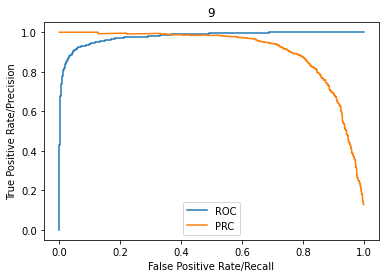

PRC AUC:0.9055242707229748
ROC AUC:0.9778955555555555


In [33]:
fpr10, tpr10, thresholds10 = roc_curve(Y_test[:,9], probs[:, 9])
prec10, recall10, thresholds10 = precision_recall_curve(Y_test[:,9], probs[:, 9])

plt.plot(fpr10,tpr10,label="ROC")
plt.plot(recall10,prec10,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('9')
plt.show()

print("PRC AUC:" + str(auc(recall10, prec10)))
print("ROC AUC:" + str(auc(fpr10, tpr10)))